In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import os
from IPython.display import display

# Load Models

In [2]:
chapterName = "variational_autoencoder-svh"
output_folder = "/home/andykamp/master/quantify_seismic_similarity/notebooks/" + chapterName
generator_path = output_folder + "/generator_entrop.hdf5"#"/generator.hdf5" # TODO REMEMBER TO CHANGE
generator = keras.models.load_model(generator_path)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/home/andykamp/envs/master/lib/python3.7/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# Need to re-include loss functions so model knows how to load them
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(_x_decoded_var + var_epsilon)
            + 0.5 * K.square(x - x_decoded_mean) / (_x_decoded_var + var_epsilon))
    loss = K.sum(loss, axis=-1)
    return K.mean(loss)

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

vae_path = output_folder + "/vae_entrop.hdf5" # TODOR EMEMBER TO CHANGE
vae = keras.models.load_model(vae_path, custom_objects={'vae_loss': vae_loss}, compile=False)

In [4]:
n_components = 1000
pca_model_file = output_folder+ '/pca_%d.pkl' % n_components
#pca_model_file = output_folder + '/pca_500.pkl'
pca = joblib.load(pca_model_file)
n_components = pca.n_components_
print(pca, n_components)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) 1000


# Sample Some Random Images

In [5]:
digit_size = 64
img_rows, img_cols, img_chns = 64, 64, 1
latent_dim = 512#*2

Using the generator network (decoder), we'll sample some from our isotropic standard Gaussians and generate a grid of 10x10 images.

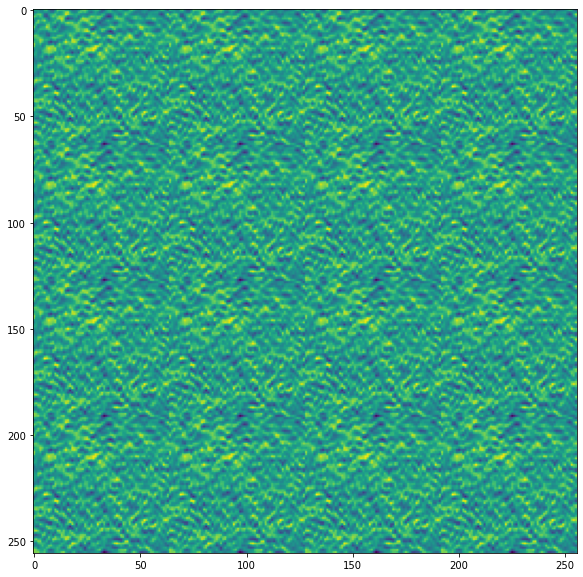

In [6]:
n = 4
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        #print(z_sample.shape)
        x_decoded = generator.predict(z_sample, batch_size=1)
        x_recon = pca.inverse_transform(x_decoded)
        #print(x_recon.shape)
        #plt.imshow(pca.inverse_transform(x_decoded)[0].reshape(digit_size, digit_size))
        #plt.show()
        x_recon *= 255.
        digit = x_recon.reshape(digit_size, digit_size)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit#.astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Definitely a quite blurry but definitely some good images that came out.  There are a few that are much clearer than others.  VAEs are known to produce blurry images compared to GANs.

# VAE Analogies

For analogies, we'll take one of the images from our original sample and then pump it through the entire VAE pipeline.  Under the hood, the network should estimate the latent mean and variance for that sample, and then use the generator network to decode it into a "similar" looking image that sampled from our shifted/scaled latent Gaussian random variable.

In [7]:
#filename = output_folder + "/rba_data_inline.npy"
filename = output_folder + "/grey_data_inline.npy"
if not os.path.exists(filename):
    print("Cannot find data. go to PCA nootebook and generate ittttt")
else: 
    print("Found rgba data")
    data = np.load(filename)
X_dataset, y_dataset = data, np.arange(0, data.shape[0])

# Use a nice round number divisible by our batch size
N=630000

X_dataset, y_dataset = X_dataset[:N], y_dataset[:N]
print ("Full Dataset - DType X=%s, y=%s" % (X_dataset.dtype, y_dataset.dtype))
print ("Full Dataset - Shape X=%s, y=%s" % (X_dataset.shape, y_dataset.shape))

Found rgba data
Full Dataset - DType X=float64, y=int64
Full Dataset - Shape X=(84480, 64, 64, 1), y=(84480,)


In [8]:
def random_image(digit):
    assert 0 <= digit <= 9
    while True:
        index = np.random.randint(0, len(X_dataset))
        if y_dataset[index] == digit:
            return X_dataset[index]

(16, 64, 64)


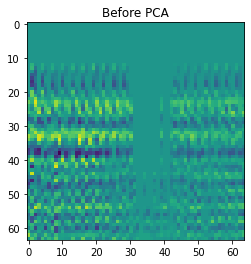

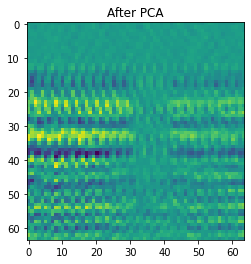

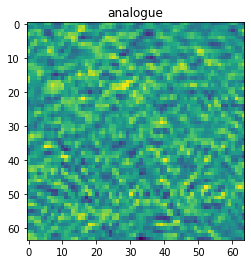

In [9]:
batch_size = 16

# draw random image
index = np.random.randint(0, len(X_dataset))
image =  X_dataset[10][:,:,0]

# Create batch to send through our network
X_sample = np.stack([image] * batch_size)
batch = pca.transform(X_sample.reshape(batch_size, -1))
batch_recon = pca.inverse_transform(batch)
x_decoded = vae.predict(batch, batch_size=batch_size)
# Convert back to RGB format
x_recon = pca.inverse_transform(x_decoded)
analogue = x_recon.reshape(batch_size, digit_size, digit_size)
print(analogue.shape)

plt.imshow(image)
plt.title("Before PCA")
plt.show()


plt.imshow(batch_recon[0].reshape(digit_size, digit_size))
plt.title("After PCA")
plt.show()



plt.imshow(analogue[0])
plt.title("analogue")
plt.show()


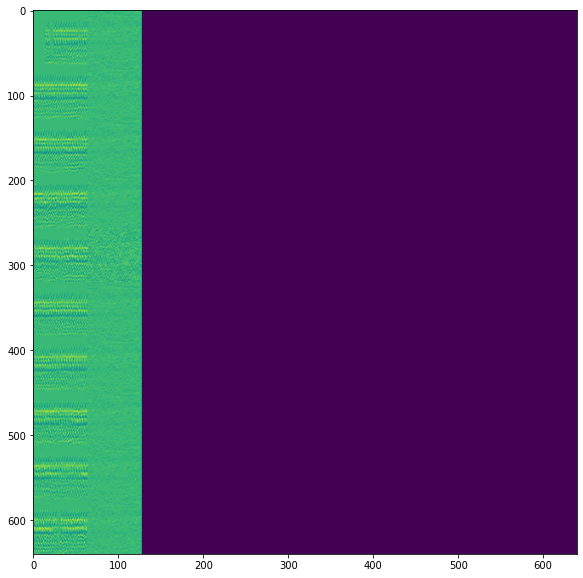

In [17]:
batch_size = 16
figure = np.zeros((digit_size * 10, digit_size * 10))

for i in range(0, 10):
    image = random_image(i)[:,:,0]
    
    # Create batch to send through our network
    X_sample = np.stack([image] * batch_size)
    batch = pca.transform(X_sample.reshape(batch_size, -1))
    x_decoded = vae.predict(batch, batch_size=batch_size)
    
    # Convert back to RGB format
    x_recon = np.clip(pca.inverse_transform(x_decoded), 0.0, .999)
    #x_recon *= 255.
    analogue = x_recon.reshape(batch_size, digit_size, digit_size)

    # First column is our original imge
    d_x = i * digit_size
    d_y = 0
    figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = image#.astype(int)
    last = [image]
   
    # Rest of the columns are analogies, attempting to select ones that are different
    for j in range(1, 2):
        d_x = i * digit_size
        d_y = j * digit_size
        best_val = 0
        best_img = None
        for k in range(j * 8, (j + 1) * 8):
            val = np.mean([np.abs(l - analogue[k]).mean() for l in last])
            if val >= best_val:
                best_val = val
                best_img = analogue[k]
                
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = best_img#.astype(int)
        last.append(best_img)

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Analogies are actually pretty interesting.  I was hoping for rows of all the same number, not quite that but close!  There is of course similarities in terms of colour and style.  The generated images are much blurrier, probably because the model hasn't fit the data that well.